# 🚨 异常检测（Anomaly Detection）

> 在海量数据中发现「与众不同」的点

---

## 📚 学习目标

完成本Notebook后，你将能够：

- ✅ 理解异常检测的定义、类型和应用场景
- ✅ 掌握基于统计的异常检测方法（3-Sigma、Z-Score）
- ✅ 理解并实现 LOF（局部异常因子）算法
- ✅ 掌握 Isolation Forest（孤立森林）的原理和应用
- ✅ 了解 One-Class SVM 的工作机制
- ✅ 学会选择合适的异常检测算法
- ✅ 在真实场景中应用异常检测

---

## 1. 什么是异常检测？

### 1.1 定义

**异常检测（Anomaly Detection）** 是指识别数据中与大多数样本显著不同的观测值的过程。

**其他名称**：
- Outlier Detection（离群点检测）
- Novelty Detection（新奇检测）
- Exception Detection（例外检测）

### 1.2 异常的类型

#### 类型1：点异常（Point Anomaly）
- **定义**：单个数据点相对于其他数据异常
- **示例**：信用卡交易中突然出现的大额消费

#### 类型2：上下文异常（Contextual Anomaly）
- **定义**：在特定上下文中才是异常
- **示例**：夏天35°C正常，冬天35°C异常

#### 类型3：集体异常（Collective Anomaly）
- **定义**：一组数据点一起出现时异常
- **示例**：心电图中的异常波形序列

### 1.3 应用场景

| 领域 | 应用 | 异常含义 |
|------|------|----------|
| **金融** | 信用卡欺诈检测 | 异常交易模式 |
| **网络安全** | 入侵检测 | 恶意访问行为 |
| **医疗** | 疾病诊断 | 异常生理指标 |
| **工业** | 设备故障预测 | 传感器异常读数 |
| **零售** | 库存管理 | 销量突变 |
| **社交网络** | 虚假账号检测 | 异常行为模式 |

### 1.4 异常检测 vs 监督学习分类

| 特性 | 异常检测 | 监督学习 |
|------|----------|----------|
| **标签** | 通常无标签（无监督） | 需要大量标签 |
| **类别平衡** | 异常样本极少 | 相对平衡 |
| **异常类型** | 未知的新型异常 | 已知类别 |
| **目标** | 发现「不同」 | 学习「相似」 |

**为什么不用分类？**
- ❌ 异常样本太少，无法训练分类器
- ❌ 未来的异常可能是新型的，训练集中没有
- ✅ 异常检测只需学习「正常」是什么样

---

## 2. 环境准备

In [2]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 异常检测算法
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

# 数据生成和预处理
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler

# 评估
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    roc_curve, auc, roc_auc_score
)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',  # macOS通用
    'PingFang SC',       # macOS系统字体
    'STHeiti',           # 华文黑体
    'Heiti TC',          # 黑体-繁
    'SimHei',            # 黑体
]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置随机种子
np.random.seed(42)

print("✅ 环境准备完成！")
print(f"   NumPy版本: {np.__version__}")
print(f"   Pandas版本: {pd.__version__}")

✅ 环境准备完成！
   NumPy版本: 1.24.3
   Pandas版本: 2.0.3


## 3. 基础方法：统计异常检测

### 3.1 3-Sigma 规则（Three-Sigma Rule）

#### 理论基础

**核心思想**：对于正态分布，99.7% 的数据落在均值 $\mu$ 的 3 倍标准差 $\sigma$ 范围内。

**数学表达**：

$$z = \frac{x - \mu}{\sigma}$$

| 符号 | 含义 | 说明 |
|------|------|------|
| $x$ | 观测值 | 要判断的数据点 |
| $\mu$ | 均值 | 数据的中心位置，$\mu = \frac{1}{n}\sum_{i=1}^{n} x_i$ |
| $\sigma$ | 标准差 | 数据的离散程度，$\sigma = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^2}$ |
| $z$ | Z-score（标准分数） | 观测值距均值多少个标准差 |

**判断规则**：

$$\text{异常} = \begin{cases}
\text{True} & \text{if } |z| > 3 \\
\text{False} & \text{otherwise}
\end{cases}$$

**直观理解**：
- $|z| \leq 1$：68% 的数据落在这里（正常）
- $1 < |z| \leq 2$：27% 的数据（可疑）
- $2 < |z| \leq 3$：4.3% 的数据（较异常）
- $|z| > 3$：0.3% 的数据（**异常**）

---

### 3.2 从零实现：3-Sigma 异常检测

3-Sigma 异常检测结果
数据总数: 505
检测到的异常数量: 7
异常占比: 1.39%
\n数据统计:
  均值 μ: 50.19
  标准差 σ: 10.62
  3σ 范围: [18.32, 82.05]


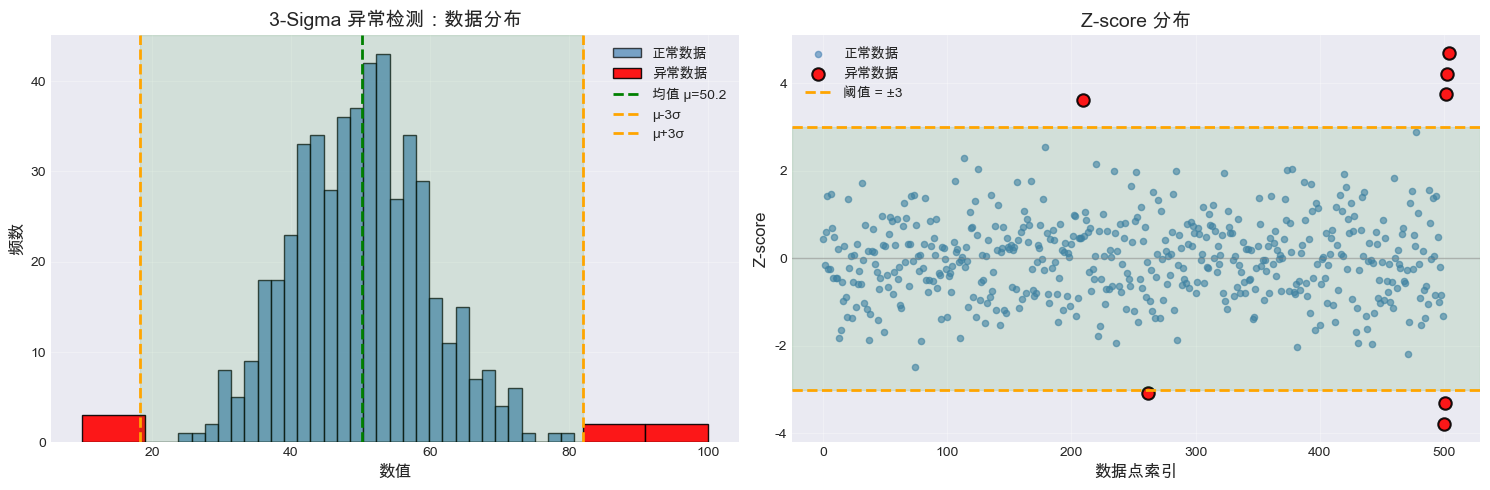

\n💡 观察：
  - 绿色区域：正常数据的 99.7% 应该落在 ±3σ 范围内
  - 红色点：Z-score 超过 ±3 的异常值
  - 橙色线：±3σ 阈值


In [3]:
# ============================================================================
# 3-Sigma 异常检测（从零实现）
# ============================================================================

def three_sigma_detection(data, threshold=3):
    """
    使用 3-Sigma 规则检测异常值
    
    原理：
    对于正态分布的数据，99.7% 的值落在 μ ± 3σ 范围内，
    超出此范围的视为异常。
    
    参数：
    --------
    data : array-like, shape (n_samples,)
        一维数据数组
    threshold : float, default=3
        标准差的倍数，默认为3
    
    返回：
    --------
    is_anomaly : ndarray, shape (n_samples,)
        布尔数组，True表示异常
    z_scores : ndarray, shape (n_samples,)
        Z-score 数组
    """
    # 步骤1：计算均值 μ
    # 公式：μ = (1/n) * Σx_i
    mu = np.mean(data)
    
    # 步骤2：计算标准差 σ
    # 公式：σ = sqrt((1/n) * Σ(x_i - μ)^2)
    sigma = np.std(data)
    
    # 步骤3：计算每个点的 Z-score
    # 公式：z = (x - μ) / σ
    # 含义：数据点距离均值多少个标准差
    z_scores = (data - mu) / sigma
    
    # 步骤4：判断异常
    # 规则：|z| > threshold 为异常
    is_anomaly = np.abs(z_scores) > threshold
    
    return is_anomaly, z_scores


# ============================================================================
# 演示：在一维数据上应用 3-Sigma
# ============================================================================

# 生成测试数据：大部分正常数据 + 少量异常值
np.random.seed(42)

# 正常数据：服从 N(50, 10)
normal_data = np.random.normal(loc=50, scale=10, size=500)

# 异常数据：远离正常范围
anomalies = np.array([10, 15, 90, 95, 100])

# 合并数据
data_1d = np.concatenate([normal_data, anomalies])

# 应用 3-Sigma 检测
is_anomaly, z_scores = three_sigma_detection(data_1d)

# 统计结果
n_anomalies = np.sum(is_anomaly)
anomaly_indices = np.where(is_anomaly)[0]

print("=" * 60)
print("3-Sigma 异常检测结果")
print("=" * 60)
print(f"数据总数: {len(data_1d)}")
print(f"检测到的异常数量: {n_anomalies}")
print(f"异常占比: {n_anomalies / len(data_1d) * 100:.2f}%")
print(f"\\n数据统计:")
print(f"  均值 μ: {np.mean(data_1d):.2f}")
print(f"  标准差 σ: {np.std(data_1d):.2f}")
print(f"  3σ 范围: [{np.mean(data_1d) - 3*np.std(data_1d):.2f}, {np.mean(data_1d) + 3*np.std(data_1d):.2f}]")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 子图1：数据分布直方图
ax1 = axes[0]
ax1.hist(data_1d[~is_anomaly], bins=30, alpha=0.7, color='steelblue', 
         edgecolor='black', label='正常数据')
ax1.hist(data_1d[is_anomaly], bins=10, alpha=0.9, color='red', 
         edgecolor='black', label='异常数据')

# 标注均值和3σ线
mean_val = np.mean(data_1d)
std_val = np.std(data_1d)
ax1.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'均值 μ={mean_val:.1f}')
ax1.axvline(mean_val - 3*std_val, color='orange', linestyle='--', linewidth=2, label=f'μ-3σ')
ax1.axvline(mean_val + 3*std_val, color='orange', linestyle='--', linewidth=2, label=f'μ+3σ')

# 填充3σ范围
ax1.axvspan(mean_val - 3*std_val, mean_val + 3*std_val, alpha=0.1, color='green')

ax1.set_xlabel('数值', fontsize=12)
ax1.set_ylabel('频数', fontsize=12)
ax1.set_title('3-Sigma 异常检测：数据分布', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 子图2：Z-score 散点图
ax2 = axes[1]
x_indices = np.arange(len(data_1d))
ax2.scatter(x_indices[~is_anomaly], z_scores[~is_anomaly], 
           c='steelblue', s=20, alpha=0.6, label='正常数据')
ax2.scatter(x_indices[is_anomaly], z_scores[is_anomaly], 
           c='red', s=80, alpha=0.9, edgecolors='black', linewidths=1.5, label='异常数据')

# 标注阈值线
ax2.axhline(3, color='orange', linestyle='--', linewidth=2, label='阈值 = ±3')
ax2.axhline(-3, color='orange', linestyle='--', linewidth=2)
ax2.axhline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

# 填充正常范围
ax2.axhspan(-3, 3, alpha=0.1, color='green')

ax2.set_xlabel('数据点索引', fontsize=12)
ax2.set_ylabel('Z-score', fontsize=12)
ax2.set_title('Z-score 分布', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\n💡 观察：")
print(f"  - 绿色区域：正常数据的 99.7% 应该落在 ±3σ 范围内")
print(f"  - 红色点：Z-score 超过 ±3 的异常值")
print(f"  - 橙色线：±3σ 阈值")

## 4. 基于密度的方法：LOF（局部异常因子）

### 4.1 LOF 理论

**LOF** (Local Outlier Factor) 是一种基于密度的异常检测算法，由 Breunig 等人在 2000 年提出。

**核心思想**：
- 比较一个点与其邻居的局部密度
- 如果一个点的密度**远低于**其邻居的密度，则该点是异常
- 适合检测**局部异常**（密度不同的簇中的异常点）

**为什么需要 LOF？**

3-Sigma 假设数据是全局均匀分布的，但真实数据往往有多个密度不同的簇：

```
密集簇        稀疏簇
  ●●●          ○  ○
  ●●●         ○    ○
  ●●●          ○  ○
    ✗         ← 这个点在稀疏簇中是正常的
              但在密集簇附近就是异常
```

LOF 能够处理这种**局部密度差异**。

---

### 4.2 LOF 算法详解

LOF 算法分为以下几个步骤，每一步都有明确的数学定义：

---

#### 📐 步骤1：计算 k-距离（k-distance）

**定义**：点 $A$ 到第 $k$ 个最近邻居的距离

$$d_k(A) = \text{distance}(A, \text{k-th nearest neighbor of } A)$$

| 符号 | 含义 | 说明 |
|------|------|------|
| $d_k(A)$ | k-距离 | 点 A 到其第 k 个最近邻居的欧氏距离 |
| $k$ | 邻居数量参数 | 通常设置为 10-20 |

**示例**：如果 $k=3$，$d_3(A)$ 就是点 A 到第 3 近的邻居的距离。

---

#### 📐 步骤2：定义 k-邻域（k-neighborhood）

**定义**：所有到点 $A$ 的距离 $\leq d_k(A)$ 的点的集合

$$N_k(A) = \{B \in \text{Dataset} \mid \text{distance}(A, B) \leq d_k(A)\}$$

| 符号 | 含义 | 说明 |
|------|------|------|
| $N_k(A)$ | k-邻域 | 点 A 的 k 个（或更多）最近邻居的集合 |

**注意**：由于可能存在距离相等的点，$|N_k(A)|$ 可能 $\geq k$。

---

#### 📐 步骤3：计算可达距离（Reachability Distance）

**定义**：点 $B$ 到点 $A$ 的可达距离

$$\text{reach-dist}_k(A, B) = \max\{d_k(B), \text{distance}(A, B)\}$$

| 符号 | 含义 | 直观理解 |
|------|------|----------|
| $\text{reach-dist}_k(A, B)$ | 可达距离 | 从 B 到 A 的"真实距离"或 B 的 k-邻域半径（取较大值） |
| $d_k(B)$ | B 的 k-距离 | B 的 k-邻域半径 |
| $\text{distance}(A, B)$ | 欧氏距离 | A 和 B 之间的真实距离 |

**为什么要用 max？**

- 如果 $A$ 在 $B$ 的 k-邻域**内**：$\text{distance}(A, B) < d_k(B)$ → 使用 $d_k(B)$（平滑距离）
- 如果 $A$ 在 $B$ 的 k-邻域**外**：$\text{distance}(A, B) > d_k(B)$ → 使用真实距离

**目的**：减少统计波动，使算法更稳定。

---

#### 📐 步骤4：计算局部可达密度（Local Reachability Density）

**定义**：点 $A$ 的局部可达密度

$$\text{lrd}_k(A) = \frac{1}{\frac{\sum_{B \in N_k(A)} \text{reach-dist}_k(A, B)}{|N_k(A)|}}$$

简化为：

$$\text{lrd}_k(A) = \frac{|N_k(A)|}{\sum_{B \in N_k(A)} \text{reach-dist}_k(A, B)}$$

| 符号 | 含义 | 直观理解 |
|------|------|----------|
| $\text{lrd}_k(A)$ | 局部可达密度 | 点 A 附近的密度（密度越高，值越大） |
| 分子 $\|N_k(A)\|$ | 邻居数量 | 通常约等于 k |
| 分母 | 平均可达距离 | A 到其所有邻居的平均可达距离 |

**物理意义**：
- **密集区域的点**：邻居很近 → 分母小 → $\text{lrd}$ **大** → 密度高
- **稀疏区域的点**：邻居很远 → 分母大 → $\text{lrd}$ **小** → 密度低

---

#### 📐 步骤5：计算 LOF（局部异常因子）

**定义**：点 $A$ 的 LOF 值

$$\text{LOF}_k(A) = \frac{\sum_{B \in N_k(A)} \frac{\text{lrd}_k(B)}{\text{lrd}_k(A)}}{|N_k(A)|}$$

简化理解：

$$\text{LOF}_k(A) = \frac{\text{平均}(\text{邻居的密度})}{\text{自己的密度}}$$

| 符号 | 含义 | 直观理解 |
|------|------|----------|
| $\text{LOF}_k(A)$ | 局部异常因子 | A 的异常程度分数 |
| $\text{lrd}_k(B)$ | 邻居 B 的密度 | B 所在区域的密度 |
| $\text{lrd}_k(A)$ | A 的密度 | A 所在区域的密度 |

**判断规则**：

| LOF 值 | 含义 | 判断 |
|--------|------|------|
| $\text{LOF} \approx 1$ | A 的密度与邻居相似 | **正常点** |
| $\text{LOF} \ll 1$ | A 的密度**远高于**邻居 | 不太可能（密集簇中心） |
| $\text{LOF} \gg 1$ | A 的密度**远低于**邻居 | **异常点**（在密集区域外） |

**阈值选择**：
- 通常设置 $\text{LOF} > 1.5$ 或 $2.0$ 为异常
- 也可以取 LOF 分数最高的 top-N 个点

---

### 4.3 LOF 算法总结

**完整流程**：

1. **输入**：数据集 $X$，参数 $k$
2. **对每个点 $A$**：
   - 找到 $k$ 个最近邻居 → $N_k(A)$
   - 计算 k-距离 → $d_k(A)$
   - 对每个邻居 $B$，计算可达距离 → $\text{reach-dist}_k(A, B)$
   - 计算局部可达密度 → $\text{lrd}_k(A)$
   - 计算 LOF → $\text{LOF}_k(A)$
3. **输出**：每个点的 LOF 分数

**时间复杂度**：$O(n^2)$（计算所有点对之间的距离）

---

### 4.4 从零实现：LOF 算法

In [7]:
# ============================================================================
# LOF（局部异常因子）从零实现
# ============================================================================

from sklearn.neighbors import NearestNeighbors

class SimpleLOF:
    """
    LOF（Local Outlier Factor）从零实现
    
    算法流程：
    1. 对每个点，找到 k 个最近邻居
    2. 计算 k-距离和可达距离
    3. 计算局部可达密度（LRD）
    4. 计算局部异常因子（LOF）
    """
    
    def __init__(self, n_neighbors=20):
        """
        参数：
        ----------
        n_neighbors : int
            k 的值，邻居数量，通常设置为 10-20
        """
        self.n_neighbors = n_neighbors
        
    def fit_predict(self, X):
        """
        计算每个点的 LOF 分数
        
        参数：
        ----------
        X : ndarray, shape (n_samples, n_features)
            输入数据
        
        返回：
        ----------
        lof_scores : ndarray, shape (n_samples,)
            每个点的 LOF 分数
        """
        n_samples = X.shape[0]
        
        # ====================================================================
        # 步骤 1: 找到每个点的 k 个最近邻居
        # ====================================================================
        # 使用 sklearn 的 NearestNeighbors 加速计算
        # n_neighbors+1 是因为点自己也会被包含在内
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors + 1)
        nbrs.fit(X)
        
        # distances: shape (n_samples, n_neighbors+1)
        # indices: shape (n_samples, n_neighbors+1)
        # 第一列是点自己（距离为0），所以我们从第二列开始
        distances, indices = nbrs.kneighbors(X)
        
        # 去掉自己，只保留真正的邻居
        # k_distances: shape (n_samples, n_neighbors)
        k_distances = distances[:, 1:]  # 到邻居的距离
        k_indices = indices[:, 1:]      # 邻居的索引
        
        # ====================================================================
        # 步骤 2: 计算 k-距离（到第 k 个邻居的距离）
        # ====================================================================
        # k_distance[i] = 点 i 到第 k 个邻居的距离
        # shape: (n_samples,)
        k_distance = k_distances[:, -1]  # 最后一列是第 k 个邻居
        
        print(f"📊 步骤 1-2 完成：找到每个点的 {self.n_neighbors} 个邻居")
        print(f"   k-距离范围: [{k_distance.min():.3f}, {k_distance.max():.3f}]")
        
        # ====================================================================
        # 步骤 3: 计算可达距离矩阵
        # ====================================================================
        # reach_dist[i, j] = max(k_distance[j], distance(i, j))
        # 即：从点 j 到点 i 的可达距离
        
        # 初始化可达距离矩阵
        # shape: (n_samples, n_neighbors)
        reach_distances = np.zeros_like(k_distances)
        
        for i in range(n_samples):
            for j_idx, neighbor_idx in enumerate(k_indices[i]):
                # 点 i 到邻居 neighbor_idx 的真实距离
                real_dist = k_distances[i, j_idx]
                
                # 邻居的 k-距离
                neighbor_k_dist = k_distance[neighbor_idx]
                
                # 可达距离 = max(neighbor的k-距离, 真实距离)
                reach_distances[i, j_idx] = max(neighbor_k_dist, real_dist)
        
        print(f"📊 步骤 3 完成：计算可达距离")
        
        # ====================================================================
        # 步骤 4: 计算局部可达密度（LRD）
        # ====================================================================
        # lrd[i] = |N_k(i)| / sum(reach_dist(i, j) for j in N_k(i))
        # 即：邻居数量 / 平均可达距离
        
        # 计算每个点的平均可达距离
        # shape: (n_samples,)
        mean_reach_dist = reach_distances.mean(axis=1)
        
        # 局部可达密度 = 1 / 平均可达距离
        # 为了避免除以0，加一个小的 epsilon
        lrd = 1.0 / (mean_reach_dist + 1e-10)
        
        print(f"📊 步骤 4 完成：计算局部可达密度（LRD）")
        print(f"   LRD 范围: [{lrd.min():.3f}, {lrd.max():.3f}]")
        
        # ====================================================================
        # 步骤 5: 计算 LOF（局部异常因子）
        # ====================================================================
        # LOF[i] = (sum(lrd[j] / lrd[i] for j in N_k(i))) / |N_k(i)|
        # 即：邻居的平均密度 / 自己的密度
        
        lof_scores = np.zeros(n_samples)
        
        for i in range(n_samples):
            # 获取点 i 的所有邻居的 LRD
            neighbors_lrd = lrd[k_indices[i]]
            
            # 计算密度比的平均值
            # LOF = mean(neighbors_lrd / lrd[i])
            lof_scores[i] = neighbors_lrd.mean() / lrd[i]
        
        print(f"📊 步骤 5 完成：计算 LOF 分数")
        print(f"   LOF 范围: [{lof_scores.min():.3f}, {lof_scores.max():.3f}]")
        
        return lof_scores


# ============================================================================
# 测试 LOF：生成包含异常点的 2D 数据
# ============================================================================

print("\\n" + "="*60)
print("LOF 异常检测演示")
print("="*60 + "\\n")

# 生成数据：两个密度不同的正常簇 + 异常点
np.random.seed(42)

# 簇 1：密集簇（100个点）
cluster1 = np.random.randn(100, 2) * 0.5 + [2, 2]

# 簇 2：稀疏簇（50个点）
cluster2 = np.random.randn(50, 2) * 1.5 + [8, 8]

# 异常点：远离两个簇的孤立点
anomalies = np.array([
    [0, 6],    # 在两个簇之间
    [5, 0],    # 远离簇
    [10, 3],   # 远离簇
    [6, 10],   # 远离簇
])

# 合并数据
X_lof = np.vstack([cluster1, cluster2, anomalies])
y_true = np.array([0]*100 + [0]*50 + [1]*4)  # 1 表示异常

print(f"数据集大小: {X_lof.shape}")
print(f"正常点: {np.sum(y_true == 0)}, 异常点: {np.sum(y_true == 1)}")

# 应用 LOF
lof_detector = SimpleLOF(n_neighbors=20)
lof_scores = lof_detector.fit_predict(X_lof)

# 根据 LOF 分数判断异常（LOF > 1.5）
threshold = 1.5
predictions = (lof_scores > threshold).astype(int)

print(f"\\n检测结果：")
print(f"  阈值: {threshold}")
print(f"  检测到的异常点数量: {np.sum(predictions == 1)}")

\n============================================================
LOF 异常检测演示
============================================================\n
数据集大小: (154, 2)
正常点: 150, 异常点: 4
📊 步骤 1-2 完成：找到每个点的 20 个邻居
   k-距离范围: [0.321, 5.617]
📊 步骤 3 完成：计算可达距离
📊 步骤 4 完成：计算局部可达密度（LRD）
   LRD 范围: [0.208, 2.879]
📊 步骤 5 完成：计算 LOF 分数
   LOF 范围: [0.942, 6.915]
\n检测结果：
  阈值: 1.5
  检测到的异常点数量: 9


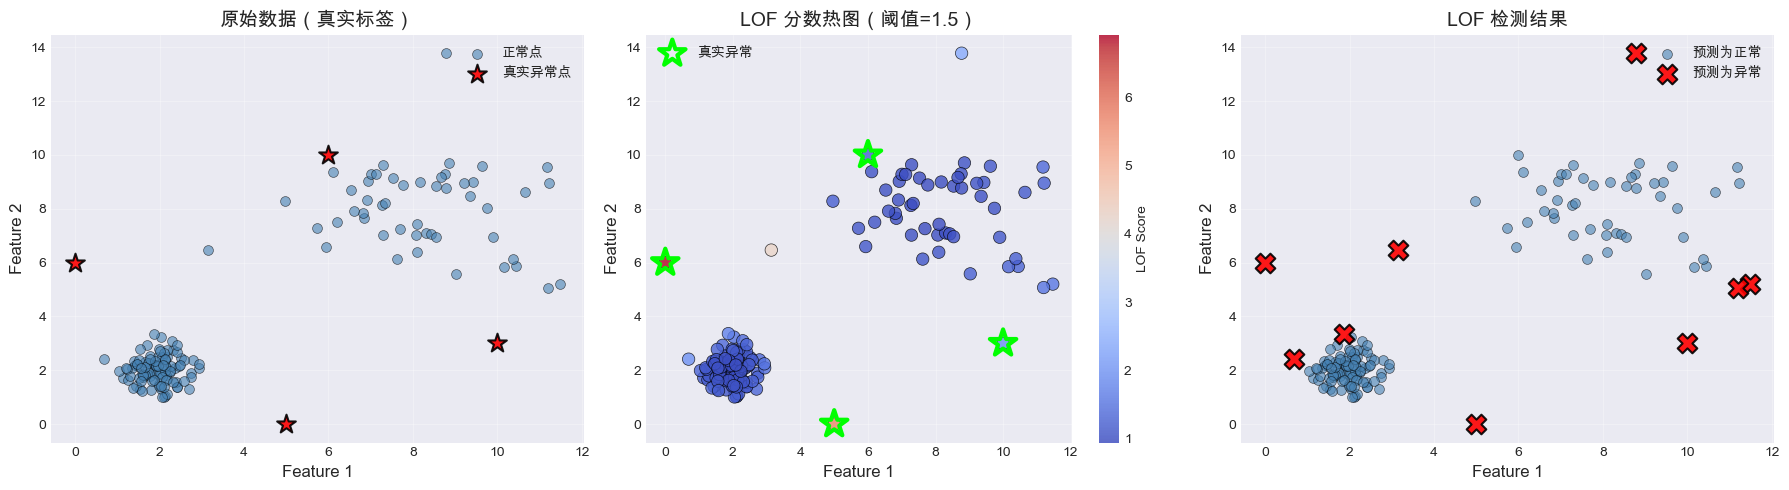

\n============================================================
检测性能评估
\n混淆矩阵:
[[144   6]
 [  1   3]]
\n  TN (正常预测为正常): 144
  FP (正常预测为异常): 6
  FN (异常预测为正常): 1
  TP (异常预测为异常): 3
\n分类报告:
              precision    recall  f1-score   support

          正常       0.99      0.96      0.98       150
          异常       0.33      0.75      0.46         4

    accuracy                           0.95       154
   macro avg       0.66      0.85      0.72       154
weighted avg       0.98      0.95      0.96       154

💡 观察：
  - LOF 分数接近 1：点的密度与邻居相似（正常）
  - LOF 分数 > 1.5：点的密度远低于邻居（异常）
  - 两个簇的密度不同，但 LOF 能识别局部异常


In [8]:
# ============================================================================
# 可视化 LOF 结果
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 子图1：原始数据（带真实标签）
ax1 = axes[0]
ax1.scatter(X_lof[y_true==0, 0], X_lof[y_true==0, 1],
           c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
           label='正常点')
ax1.scatter(X_lof[y_true==1, 0], X_lof[y_true==1, 1],
           c='red', s=200, alpha=0.9, marker='*', edgecolors='black', linewidth=1.5,
           label='真实异常点')
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.set_title('原始数据（真实标签）', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 子图2：LOF 分数热图
ax2 = axes[1]
scatter = ax2.scatter(X_lof[:, 0], X_lof[:, 1],
                     c=lof_scores, cmap='coolwarm', s=80, alpha=0.8,
                     edgecolors='black', linewidth=0.5)
# 标注真实异常点的位置
for idx in np.where(y_true == 1)[0]:
    ax2.scatter(X_lof[idx, 0], X_lof[idx, 1],
               marker='*', s=400, facecolors='none', edgecolors='lime',
               linewidth=3, label='真实异常' if idx == np.where(y_true==1)[0][0] else '')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_title(f'LOF 分数热图（阈值={threshold}）', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('LOF Score', fontsize=10)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 子图3：检测结果
ax3 = axes[2]
ax3.scatter(X_lof[predictions==0, 0], X_lof[predictions==0, 1],
           c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
           label='预测为正常')
ax3.scatter(X_lof[predictions==1, 0], X_lof[predictions==1, 1],
           c='red', s=200, alpha=0.9, marker='X', edgecolors='black', linewidth=1.5,
           label='预测为异常')
ax3.set_xlabel('Feature 1', fontsize=12)
ax3.set_ylabel('Feature 2', fontsize=12)
ax3.set_title('LOF 检测结果', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 评估检测效果
from sklearn.metrics import classification_report, confusion_matrix

print("\\n" + "="*60)
print("检测性能评估")
print("="*60)
print("\\n混淆矩阵:")
cm = confusion_matrix(y_true, predictions)
print(cm)
print(f"\\n  TN (正常预测为正常): {cm[0, 0]}")
print(f"  FP (正常预测为异常): {cm[0, 1]}")
print(f"  FN (异常预测为正常): {cm[1, 0]}")
print(f"  TP (异常预测为异常): {cm[1, 1]}")

print("\\n分类报告:")
print(classification_report(y_true, predictions, target_names=['正常', '异常']))

print("💡 观察：")
print("  - LOF 分数接近 1：点的密度与邻居相似（正常）")
print("  - LOF 分数 > 1.5：点的密度远低于邻居（异常）")
print("  - 两个簇的密度不同，但 LOF 能识别局部异常")

### 4.5 sklearn 实现：LocalOutlierFactor

在理解了 LOF 的原理和从零实现后，让我们看看 sklearn 的**生产级实现**。

**sklearn.neighbors.LocalOutlierFactor** 提供了：
- ✅ 高效的实现（基于 KD-Tree 或 Ball-Tree）
- ✅ 支持多种距离度量
- ✅ 两种使用模式：**novelty detection**（新奇检测）和 **outlier detection**（异常检测）

**关键参数**：

| 参数 | 含义 | 默认值 | 说明 |
|------|------|--------|------|
| `n_neighbors` | 邻居数量 k | 20 | 对应我们手搓版本的 k 值 |
| `contamination` | 异常比例 | 'auto' | 用于设置决策阈值 |
| `novelty` | 新奇检测模式 | False | True 时可用于预测新样本 |
| `algorithm` | 邻居搜索算法 | 'auto' | 'ball_tree', 'kd_tree', 'brute' |
| `metric` | 距离度量 | 'minkowski' | 欧氏距离对应 p=2 |

**两种模式的区别**：

| 模式 | novelty=False（默认） | novelty=True |
|------|----------------------|---------------|
| **用途** | 异常检测（outlier detection） | 新奇检测（novelty detection） |
| **训练数据** | 可以包含异常点 | 应该只包含正常点 |
| **fit_predict** | ✅ 可用 | ❌ 不可用 |
| **predict** | ❌ 不可用 | ✅ 可用（用于新样本） |


In [12]:
# ============================================================================
# sklearn LOF 实现对比
# ============================================================================

from sklearn.neighbors import LocalOutlierFactor

print("="*60)
print("sklearn LocalOutlierFactor vs 手搓 SimpleLOF 对比")
print("="*60 + "\n")

# ====================================================================
# 1. 使用 sklearn LOF（与手搓版本相同的参数）
# ====================================================================

# 创建 sklearn LOF 检测器
# 注意：contamination 设置为 'auto' 时，阈值为 -1.5（对应 LOF > 1.5）
sklearn_lof = LocalOutlierFactor(
    n_neighbors=20,           # 邻居数量，与手搓版本一致
    contamination='auto',     # 自动确定阈值（约等于 LOF > 1.5）
    novelty=False,            # 异常检测模式（训练集可含异常）
    algorithm='auto',         # 自动选择最佳邻居搜索算法
    metric='euclidean'        # 欧氏距离
)

# fit_predict 返回 1（正常）或 -1（异常）
sklearn_predictions = sklearn_lof.fit_predict(X_lof)

# 获取 LOF 分数（注意：sklearn 返回的是负的 LOF 分数）
# negative_outlier_factor_ 是 -LOF，所以值越负越异常
sklearn_lof_scores = -sklearn_lof.negative_outlier_factor_

print("sklearn LOF 参数：")
print(f"  n_neighbors: {sklearn_lof.n_neighbors}")
print(f"  contamination: {sklearn_lof.contamination}")
print(f"  algorithm: {sklearn_lof.algorithm}")
print(f"  metric: {sklearn_lof.metric}")

print(f"\nsklearn LOF 结果：")
print(f"  LOF 分数范围: [{sklearn_lof_scores.min():.3f}, {sklearn_lof_scores.max():.3f}]")
print(f"  检测到的异常点数量: {np.sum(sklearn_predictions == -1)}")

# ====================================================================
# 2. 对比两个版本的结果
# ====================================================================

print("\n" + "="*60)
print("手搓版本 vs sklearn 版本对比")
print("="*60)

# 转换手搓版本的预测结果为 1/-1 格式
simple_predictions_binary = np.where(predictions == 1, -1, 1)  # 1=异常 -> -1

print(f"\n手搓 SimpleLOF：")
print(f"  LOF 分数范围: [{lof_scores.min():.3f}, {lof_scores.max():.3f}]")
print(f"  检测到的异常点数量: {np.sum(predictions == 1)}")

print(f"\nsklearn LOF：")
print(f"  LOF 分数范围: [{sklearn_lof_scores.min():.3f}, {sklearn_lof_scores.max():.3f}]")
print(f"  检测到的异常点数量: {np.sum(sklearn_predictions == -1)}")

# 计算两个版本预测结果的一致性
# sklearn: -1 = 异常，手搓: 1 = 异常
agreement = np.mean(sklearn_predictions == simple_predictions_binary)
print(f"\n预测结果一致性: {agreement*100:.1f}%")

# LOF 分数相关性
correlation = np.corrcoef(lof_scores, sklearn_lof_scores)[0, 1]
print(f"LOF 分数相关性: {correlation:.4f}")

sklearn LocalOutlierFactor vs 手搓 SimpleLOF 对比

sklearn LOF 参数：
  n_neighbors: 20
  contamination: auto
  algorithm: auto
  metric: euclidean

sklearn LOF 结果：
  LOF 分数范围: [0.942, 6.915]
  检测到的异常点数量: 9

手搓版本 vs sklearn 版本对比

手搓 SimpleLOF：
  LOF 分数范围: [0.942, 6.915]
  检测到的异常点数量: 9

sklearn LOF：
  LOF 分数范围: [0.942, 6.915]
  检测到的异常点数量: 9

预测结果一致性: 100.0%
LOF 分数相关性: 1.0000


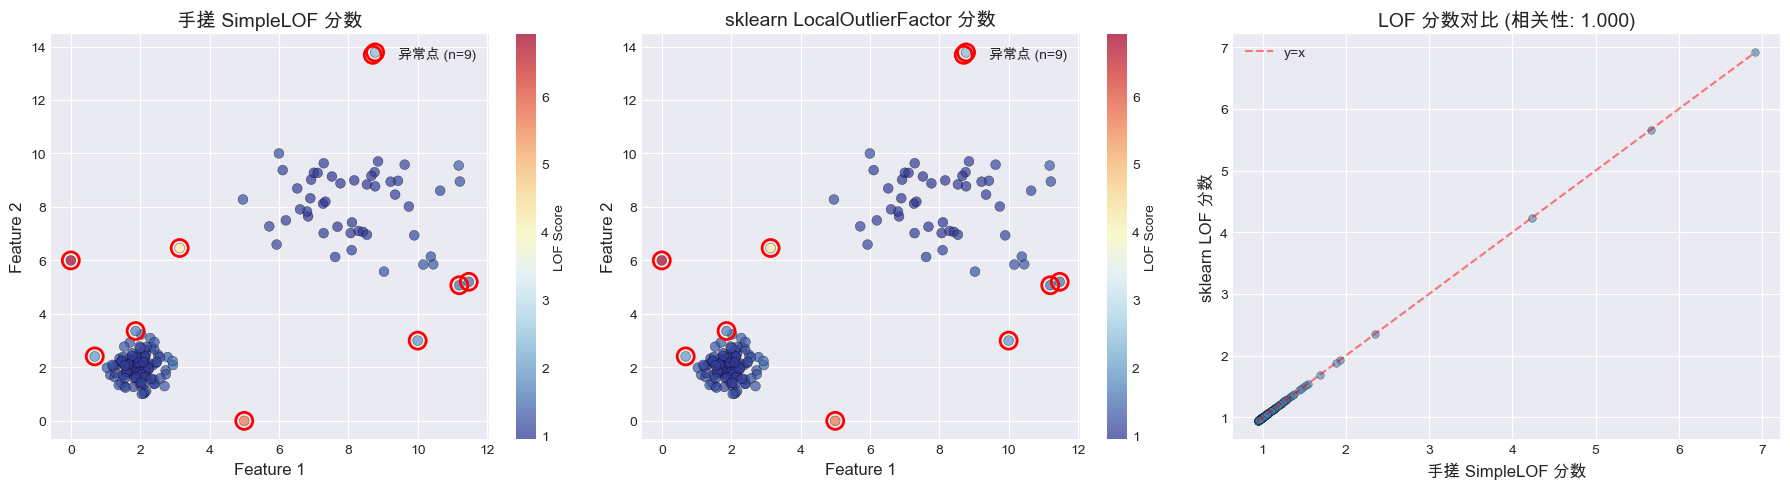

💡 观察：
  - 两个版本的 LOF 分数高度相关（应该接近 1.0）
  - 微小差异可能来自边界情况的处理方式
  - sklearn 版本在大数据集上更快（使用 KD-Tree）


In [13]:
# ============================================================================
# 可视化对比：手搓 vs sklearn
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ====================================================================
# 子图1：手搓 SimpleLOF 结果
# ====================================================================
ax1 = axes[0]
scatter1 = ax1.scatter(X_lof[:, 0], X_lof[:, 1], 
                       c=lof_scores, cmap='RdYlBu_r', 
                       s=50, alpha=0.7, edgecolors='black', linewidth=0.3)
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.set_title('手搓 SimpleLOF 分数', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='LOF Score')

# 标记异常点
anomaly_mask_simple = predictions == 1
ax1.scatter(X_lof[anomaly_mask_simple, 0], X_lof[anomaly_mask_simple, 1],
           facecolors='none', edgecolors='red', s=150, linewidth=2,
           label=f'异常点 (n={np.sum(anomaly_mask_simple)})')
ax1.legend(loc='upper right')

# ====================================================================
# 子图2：sklearn LOF 结果
# ====================================================================
ax2 = axes[1]
scatter2 = ax2.scatter(X_lof[:, 0], X_lof[:, 1], 
                       c=sklearn_lof_scores, cmap='RdYlBu_r', 
                       s=50, alpha=0.7, edgecolors='black', linewidth=0.3)
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_title('sklearn LocalOutlierFactor 分数', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='LOF Score')

# 标记异常点
anomaly_mask_sklearn = sklearn_predictions == -1
ax2.scatter(X_lof[anomaly_mask_sklearn, 0], X_lof[anomaly_mask_sklearn, 1],
           facecolors='none', edgecolors='red', s=150, linewidth=2,
           label=f'异常点 (n={np.sum(anomaly_mask_sklearn)})')
ax2.legend(loc='upper right')

# ====================================================================
# 子图3：LOF 分数散点对比
# ====================================================================
ax3 = axes[2]
ax3.scatter(lof_scores, sklearn_lof_scores, alpha=0.6, s=30, 
           c='steelblue', edgecolors='black', linewidth=0.3)
ax3.set_xlabel('手搓 SimpleLOF 分数', fontsize=12)
ax3.set_ylabel('sklearn LOF 分数', fontsize=12)
ax3.set_title(f'LOF 分数对比 (相关性: {correlation:.3f})', fontsize=14, fontweight='bold')

# 添加对角线参考
lims = [min(lof_scores.min(), sklearn_lof_scores.min()),
        max(lof_scores.max(), sklearn_lof_scores.max())]
ax3.plot(lims, lims, 'r--', alpha=0.5, label='y=x')
ax3.legend()

plt.tight_layout()
plt.savefig('lof_comparison.png', dpi=150, bbox_inches='tight',
           facecolor='white', edgecolor='none')
plt.show()

print("💡 观察：")
print("  - 两个版本的 LOF 分数高度相关（应该接近 1.0）")
print("  - 微小差异可能来自边界情况的处理方式")
print("  - sklearn 版本在大数据集上更快（使用 KD-Tree）")

### 4.6 LOF 使用建议

**常见陷阱**：

| 问题 | 解决方案 |
|------|----------|
| LOF 对不同密度的簇效果差 | ✅ 这正是 LOF 的优势，它能处理局部密度差异 |
| 数据规模太大 | 使用 `algorithm='ball_tree'` 或减少 `n_neighbors` |
| 高维数据效果差 | 先降维（PCA），再用 LOF |
| 不知道异常比例 | 使用 `contamination='auto'` |

---

## 5. 基于树的方法：Isolation Forest（孤立森林）⭐

### 5.1 Isolation Forest 理论

**Isolation Forest** 由刘飞等人在 2008 年提出，是目前最流行的异常检测算法之一。

**核心思想**：
- 异常点**很少且不同**，所以它们更容易被**孤立**（isolated）
- 通过随机分割特征空间，异常点会更快被单独隔离出来
- 异常点的**路径长度（path length）** 短，正常点的路径长度长

**直观理解**：

想象你在一片森林中寻找一个人：
- **人很多的地方**（正常点）：需要不断细分才能找到特定的人
- **一个人站在空地**（异常点）：很快就能找到

### 5.2 核心概念

#### 概念1：隔离树（Isolation Tree, iTree）

**构建过程**：

1. **随机选择**一个特征 $f$
2. **随机选择**该特征的一个分割值 $v$（在最小值和最大值之间）
3. 根据 $x_f < v$ 将数据分成两部分
4. **递归**重复，直到：
   - 每个叶子节点只有 1 个点，或
   - 达到最大深度

**关键特性**：
- ✅ 随机性：每次分割都是随机的
- ✅ 非平衡：异常点会形成更短的路径
- ✅ 快速：不需要计算距离

---

#### 概念2：路径长度（Path Length）

**定义**：从根节点到叶子节点经过的边数

$$h(x) = \text{path length of sample } x$$

| 符号 | 含义 | 说明 |
|------|------|------|
| $h(x)$ | 路径长度 | 样本 x 被隔离所需的步数 |

**示例**：

```
       根
      /  \\
    正常  x (异常)  ← h(x) = 1 (很快被隔离)
   /  \\
  正常 正常
 /  \\
正常 正常         ← 这些点的 h(·) = 3 或 4
```

---

#### 概念3：异常分数（Anomaly Score）

由于路径长度依赖于数据集大小 $n$，需要标准化：

**标准化公式**：

$$s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$

| 符号 | 含义 | 说明 |
|------|------|------|
| $s(x, n)$ | 异常分数 | 范围 [0, 1]，越接近 1 越异常 |
| $E(h(x))$ | 平均路径长度 | 在多棵树上的平均值 |
| $c(n)$ | 标准化常数 | $c(n) = 2H(n-1) - 2(n-1)/n$ |
| $H(n-1)$ | 调和数 | $H(k) = \\ln(k) + 0.5772$ |

**$c(n)$ 的作用**：
- 它是**二叉搜索树的平均路径长度**
- 用于将路径长度标准化到 [0, 1]

**判断规则**：

| 异常分数 | 含义 | 判断 |
|----------|------|------|
| $s \\approx 1$ | 路径长度远小于平均值 | **异常点** |
| $s \\approx 0.5$ | 路径长度接近平均值 | **正常点** |
| $s < 0.5$ | 路径长度大于平均值 | **非常正常**（很难被隔离） |

**阈值选择**：
- 通常设置 $s > 0.6$ 为异常
- 或选择异常分数最高的 top-N 个点

---

### 5.3 Isolation Forest 算法流程

**训练阶段**：

1. **输入**：数据集 $X$，树的数量 $t$，子采样大小 $\\psi$
2. **对每棵树 $i = 1, 2, ..., t$**：
   - 随机采样 $\\psi$ 个样本（通常 $\\psi = 256$）
   - 构建一棵隔离树 iTree
3. **输出**：森林（$t$ 棵树）

**预测阶段**：

1. **输入**：测试样本 $x$
2. **对每棵树**：
   - 计算 $x$ 的路径长度 $h_i(x)$
3. **计算**平均路径长度 $E(h(x)) = \\frac{1}{t}\\sum_{i=1}^{t} h_i(x)$
4. **计算**异常分数 $s(x, n)$
5. **输出**：异常分数

---

### 5.4 Isolation Forest 的优势

| 优势 | 说明 |
|------|------|
| **速度快** | 时间复杂度 $O(t \\psi \\log \\psi)$，线性于数据量 |
| **内存少** | 只需存储树结构 |
| **适合高维** | 随机特征选择，不受维度诅咒影响 |
| **无需距离计算** | 不像 LOF 需要计算所有点对的距离 |
| **可扩展** | 适合大规模数据（百万级） |
| **少参数** | 主要参数：树的数量、子采样大小 |

---

### 5.5 Isolation Forest 实战演示（sklearn）

Isolation Forest 异常检测演示
============================================================\n
模型参数：
  树的数量: 100
  子采样大小: auto
  预期异常比例: 0.05
\n检测结果：
  检测到的异常点数量: 8
  异常分数范围: [-0.722, -0.355]


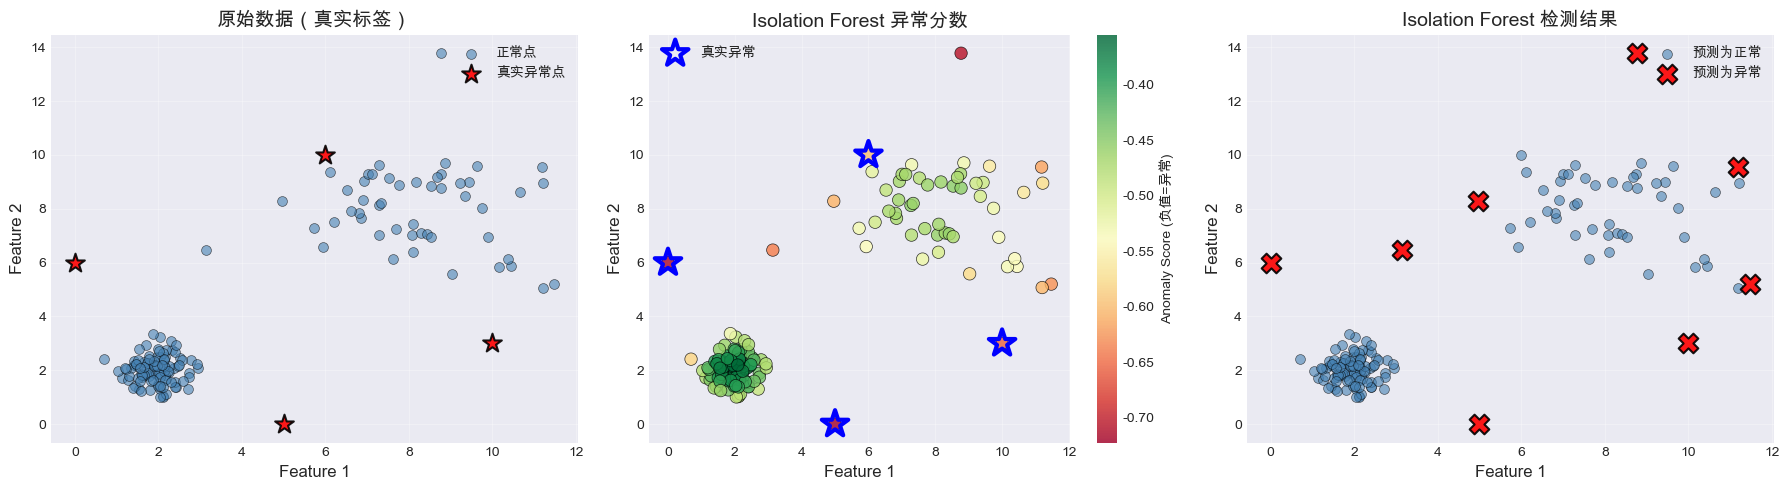

\n============================================================
检测性能评估
\n混淆矩阵:
[[145   5]
 [  1   3]]
\n分类报告:
              precision    recall  f1-score   support

          正常       0.99      0.97      0.98       150
          异常       0.38      0.75      0.50         4

    accuracy                           0.96       154
   macro avg       0.68      0.86      0.74       154
weighted avg       0.98      0.96      0.97       154

\n💡 Isolation Forest 的特点：
  - 速度快：适合大规模数据
  - 异常分数是负值：越负越异常
  - 基于路径长度：异常点更容易被隔离


In [9]:
# ============================================================================
# Isolation Forest 演示
# ============================================================================

print("="*60)
print("Isolation Forest 异常检测演示")
print("="*60 + "\\n")

# 使用之前的数据（两个簇 + 异常点）
# X_lof 和 y_true 已经在前面定义过

# 创建 Isolation Forest 模型
iso_forest = IsolationForest(
    n_estimators=100,        # 树的数量
    max_samples='auto',      # 子采样大小（'auto' = min(256, n_samples)）
    contamination=0.05,      # 预期异常比例（5%）
    max_features=1.0,        # 每次分割使用所有特征
    random_state=42
)

# 训练并预测
# 注意：sklearn 返回 1 表示正常，-1 表示异常
predictions_iso = iso_forest.fit_predict(X_lof)

# 获取异常分数（负值表示异常）
anomaly_scores = iso_forest.score_samples(X_lof)

# 转换为 0/1 标签（0=正常，1=异常）
predictions_iso_binary = (predictions_iso == -1).astype(int)

print(f"模型参数：")
print(f"  树的数量: {iso_forest.n_estimators}")
print(f"  子采样大小: {iso_forest.max_samples}")
print(f"  预期异常比例: {iso_forest.contamination}")

print(f"\\n检测结果：")
print(f"  检测到的异常点数量: {np.sum(predictions_iso_binary)}")
print(f"  异常分数范围: [{anomaly_scores.min():.3f}, {anomaly_scores.max():.3f}]")

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 子图1：原始数据
ax1 = axes[0]
ax1.scatter(X_lof[y_true==0, 0], X_lof[y_true==0, 1],
           c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
           label='正常点')
ax1.scatter(X_lof[y_true==1, 0], X_lof[y_true==1, 1],
           c='red', s=200, alpha=0.9, marker='*', edgecolors='black', linewidth=1.5,
           label='真实异常点')
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.set_title('原始数据（真实标签）', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 子图2：异常分数热图
ax2 = axes[1]
scatter = ax2.scatter(X_lof[:, 0], X_lof[:, 1],
                     c=anomaly_scores, cmap='RdYlGn', s=80, alpha=0.8,
                     edgecolors='black', linewidth=0.5)
# 标注真实异常点
for idx in np.where(y_true == 1)[0]:
    ax2.scatter(X_lof[idx, 0], X_lof[idx, 1],
               marker='*', s=400, facecolors='none', edgecolors='blue',
               linewidth=3, label='真实异常' if idx == np.where(y_true==1)[0][0] else '')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_title('Isolation Forest 异常分数', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Anomaly Score (负值=异常)', fontsize=10)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 子图3：检测结果
ax3 = axes[2]
ax3.scatter(X_lof[predictions_iso_binary==0, 0], X_lof[predictions_iso_binary==0, 1],
           c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
           label='预测为正常')
ax3.scatter(X_lof[predictions_iso_binary==1, 0], X_lof[predictions_iso_binary==1, 1],
           c='red', s=200, alpha=0.9, marker='X', edgecolors='black', linewidth=1.5,
           label='预测为异常')
ax3.set_xlabel('Feature 1', fontsize=12)
ax3.set_ylabel('Feature 2', fontsize=12)
ax3.set_title('Isolation Forest 检测结果', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 性能评估
print("\\n" + "="*60)
print("检测性能评估")
print("="*60)
print("\\n混淆矩阵:")
cm = confusion_matrix(y_true, predictions_iso_binary)
print(cm)
print(f"\\n分类报告:")
print(classification_report(y_true, predictions_iso_binary, target_names=['正常', '异常']))

print("\\n💡 Isolation Forest 的特点：")
print("  - 速度快：适合大规模数据")
print("  - 异常分数是负值：越负越异常")
print("  - 基于路径长度：异常点更容易被隔离")

## 6. 基于边界的方法：One-Class SVM ⭐

### 6.1 One-Class SVM 理论

**One-Class SVM**（一类支持向量机）是由 Schölkopf 等人在 2001 年提出的异常检测算法。

**核心思想**：
- 学习**正常数据的边界**，而不是区分两个类别
- 在高维特征空间中，找到一个**最小超球面或超平面**，包含大部分正常数据
- 边界外的点被视为异常

**直观理解**：

想象你有一堆正常的苹果：
- **传统 SVM**：需要苹果和橙子，学习如何区分它们
- **One-Class SVM**：只需要苹果，学习"苹果应该是什么样的"
- 任何不像苹果的东西（香蕉、石头）都是异常

**为什么需要 One-Class SVM？**

在很多实际应用中，我们只有正常样本，或者异常样本极少：

| 场景 | 正常样本 | 异常样本 |
|------|----------|----------|
| **新设备投产** | 大量正常运行数据 | 几乎没有故障数据 |
| **罕见疾病诊断** | 健康人体检数据 | 极少患者数据 |
| **信用卡欺诈** | 数百万正常交易 | 极少欺诈案例 |

One-Class SVM 能够**只从正常样本学习**，无需异常样本。

---

### 6.2 One-Class SVM vs 传统 SVM

| 特性 | 传统 SVM（二分类） | One-Class SVM |
|------|-------------------|--------------|
| **训练数据** | 需要正类和负类 | 只需要一类（正常） |
| **目标** | 最大化两类间的间隔 | 最大化原点到超平面的距离 |
| **决策边界** | 分离两个类别 | 包围正常数据 |
| **应用场景** | 分类问题 | 异常检测、新奇检测 |

---

### 6.3 适用场景

#### ✅ 适合使用 One-Class SVM 的场景

1. **只有正常样本**：训练数据中几乎没有异常样本
2. **异常类型未知**：不知道异常会以什么形式出现
3. **需要决策边界**：希望有明确的正常/异常分界
4. **高维数据**：特征维度较高（通过核技巧处理）

#### ❌ 不适合的场景

1. **异常样本充足**：如果有足够的异常样本，用监督学习更好
2. **超大规模数据**：One-Class SVM 的训练复杂度是 $O(n^2)$ 到 $O(n^3)$
3. **实时在线检测**：训练时间较长，不适合实时场景

---


### 6.4 One-Class SVM 数学原理详解

#### 📐 优化目标

One-Class SVM 的目标是在特征空间中找到一个**最小的超球面**或**距离原点最远的超平面**，使得大部分正常数据被包含在内。

**原始优化问题**：

$$\min_{\mathbf{w}, \rho, \boldsymbol{\xi}} \frac{1}{2} \|\mathbf{w}\|^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^{n} \xi_i$$

**约束条件**：

$$\mathbf{w}^T \phi(\mathbf{x}_i) \geq \rho - \xi_i, \quad \xi_i \geq 0, \quad i = 1, ..., n$$

| 符号 | 含义 | 说明 |
|------|------|------|
| $\mathbf{w}$ | 超平面法向量 | 定义决策边界的方向 |
| $\rho$ | 偏移量 | 超平面到原点的距离 |
| $\phi(\mathbf{x})$ | 核映射 | 将数据映射到高维特征空间 |
| $\xi_i$ | 松弛变量 | 允许部分点在边界外 |
| $\nu$ | 参数（nu） | 控制异常比例上界和支持向量下界 |
| $n$ | 样本数量 | 训练样本的总数 |


---

**📖 符号详解（读音与含义）**

| 符号 | 读音 | 数学含义 | 直观理解 |
|------|------|----------|----------|
| $\mathbf{w}$ | "w向量" | 权重向量/法向量 | 决策边界的方向 |
| $\|\mathbf{w}\|^2$ | "w的二范数平方" | 向量长度的平方 | 控制边界的紧密度 |
| $\rho$ | "rou" (罗) | 偏移量 | 超平面到原点的距离 |
| $\xi$ | "ksi" (克赛) | 希腊字母xi | 松弛变量向量 |
| $\xi_i$ | "ksi i" | 第i个松弛变量 | 样本i违反约束的程度 |
| $\boldsymbol{\xi}$ | "粗体ksi" | 松弛变量向量 | 所有样本的松弛变量集合 |
| $\nu$ | "niu" (纽) | 希腊字母nu | 控制异常比例的超参数 |
| $\phi(\mathbf{x})$ | "fai x" | 核映射函数 | 将数据映射到高维空间 |
| $\mathbf{w}^T$ | "w转置" | 向量转置 | 行向量，用于计算内积 |
| $\sum_{i=1}^{n}$ | "求和i从1到n" | 累加符号 | 对所有n个样本求和 |

**🔤 希腊字母发音提示**：
- $\xi$ (xi)：读作 "克赛" 或 "可赛"，类似英文 "ksai"
- $\rho$ (rho)：读作 "柔" 或 "罗"，类似英文 "row"
- $\nu$ (nu)：读作 "纽"，类似英文 "new"
- $\phi$ (phi)：读作 "fai"，类似英文 "fie"

**💡 关键符号深度解析**：

**1. 松弛变量 $\xi_i$**
- **$\xi_i = 0$**：样本 $\mathbf{x}_i$ 严格在边界内（完全正常）
- **$0 < \xi_i < \rho$**：样本在边界外但未越过原点（轻度异常）
- **$\xi_i \geq \rho$**：样本在原点另一侧（严重异常）

**2. 参数 $\nu$ 的双重含义**
- **上界**：训练集中最多 $\nu \times 100\%$ 的样本会被判为异常
- **下界**：至少 $\nu \times 100\%$ 的样本会成为支持向量
- **例子**：$\nu = 0.1$ → 最多10%异常，至少10%支持向量

**3. 为什么目标函数有三项？**
- **第一项 $\frac{1}{2}\|\mathbf{w}\|^2$**：防止边界过于复杂（正则化）
- **第二项 $-\rho$**：让边界尽可能远离原点（增大间隔）
- **第三项 $\frac{1}{\nu n}\sum \xi_i$**：惩罚违反约束的样本（软间隔）

这三项的平衡就是 One-Class SVM 的核心！

**目标函数的直观理解**：

- **$\frac{1}{2} \|\mathbf{w}\|^2$**：最小化，使边界尽可能"紧"
- **$-\rho$**：最大化 $\rho$，使超平面离原点尽可能远
- **$\frac{1}{\nu n} \sum \xi_i$**：惩罚违反约束的样本

---

#### 📐 参数 $\nu$ 的含义

**$\nu$ 的双重作用**：

1. **异常比例上界**：最多 $\nu$ 比例的训练样本会被判为异常
2. **支持向量下界**：至少 $\nu$ 比例的训练样本会成为支持向量

**取值范围**：$\nu \in (0, 1]$

| $\nu$ 值 | 含义 | 边界形状 |
|-----------|------|----------|
| **0.01** | 预期 1% 异常 | 非常紧的边界 |
| **0.05** | 预期 5% 异常 | 较紧的边界 |
| **0.1** | 预期 10% 异常 | 中等边界 |
| **0.5** | 预期 50% 异常 | 非常松的边界 |

**选择建议**：
- 如果知道数据中的异常比例，将 $\nu$ 设置为该值
- 如果不知道，从 0.05 或 0.1 开始尝试

---

#### 📐 核函数（Kernel Function）

One-Class SVM 使用**核技巧**将数据映射到高维空间，使得在原始空间中难以分离的数据变得可分。

**常用核函数**：

**1. RBF 核（径向基函数）**：

$$K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2\right)$$

| 参数 | 含义 | 影响 |
|------|------|------|
| $\gamma$ | 核系数 | $\gamma$ 越大，决策边界越复杂 |

- ✅ **优点**：能处理非线性数据，效果通常最好
- ❌ **缺点**：需要调优 $\gamma$ 参数

**2. Linear 核（线性）**：

$$K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^T \mathbf{x}_j$$

- ✅ **优点**：快速，可解释性强
- ❌ **缺点**：只能处理线性可分的数据

**3. Polynomial 核（多项式）**：

$$K(\mathbf{x}_i, \mathbf{x}_j) = (\gamma \mathbf{x}_i^T \mathbf{x}_j + r)^d$$

| 参数 | 含义 |
|------|------|
| $d$ | 多项式的度 |
| $r$ | 独立项 |

- ✅ **优点**：介于线性和 RBF 之间
- ❌ **缺点**：需要调优多个参数

---

#### 📐 决策函数

**决策函数**：

$$f(\mathbf{x}) = \text{sign}(\mathbf{w}^T \phi(\mathbf{x}) - \rho)$$

使用核技巧后：

$$f(\mathbf{x}) = \text{sign}\left(\sum_{i \in SV} \alpha_i K(\mathbf{x}_i, \mathbf{x}) - \rho\right)$$

| 符号 | 含义 | 说明 |
|------|------|------|
| $f(\mathbf{x})$ | 决策值 | $+1$ = 正常，$-1$ = 异常 |
| $\alpha_i$ | 拉格朗日乘子 | 支持向量的权重 |
| $SV$ | 支持向量集合 | 只有支持向量的 $\alpha_i > 0$ |

**判断规则**：

- $f(\mathbf{x}) \geq 0$：正常点（在边界内）
- $f(\mathbf{x}) < 0$：异常点（在边界外）

---

#### 📐 支持向量（Support Vectors）

**什么是支持向量？**

在 One-Class SVM 中，支持向量是那些**位于决策边界上或边界外**的训练样本。

**支持向量的特点**：

- 只有支持向量的 $\alpha_i > 0$
- 决策函数只依赖于支持向量
- 支持向量的数量 $\geq \nu \times n$

**直观理解**：

```
       正常数据密集区域
          ●●●●●
         ●●●●●●
        ●●●●●●●
       ●●●●○●●●    ← ○ 表示支持向量
      ●●●○●●●○●
     ●●●●●●●●●●
      决策边界 ↓
    ---------------
         异常区域
            ✗
```

支持向量是那些"定义边界"的关键样本。

---

### 6.5 One-Class SVM 算法总结

**完整流程**：

1. **输入**：正常样本 $\{\mathbf{x}_1, ..., \mathbf{x}_n\}$，参数 $\nu$，核函数 $K$
2. **训练**：
   - 求解优化问题，得到 $\mathbf{w}, \rho, \{\alpha_i\}$
   - 识别支持向量（$\alpha_i > 0$ 的样本）
3. **预测**：
   - 对新样本 $\mathbf{x}$，计算 $f(\mathbf{x})$
   - 如果 $f(\mathbf{x}) \geq 0$，判为正常；否则判为异常
4. **输出**：异常标签（$+1$ 或 $-1$）

**时间复杂度**：
- 训练：$O(n^2)$ 到 $O(n^3)$（取决于优化算法）
- 预测：$O(|SV|)$（只需计算与支持向量的核函数）

---


In [15]:
# ============================================================================
# One-Class SVM 演示
# ============================================================================

print("="*60)
print("One-Class SVM 异常检测演示")
print("="*60 + "\n")

# 使用之前的数据（两个簇 + 异常点）
# X_lof 和 y_true 已经在前面定义过

# ====================================================================
# 重要：One-Class SVM 对数据规模敏感，需要标准化
# ====================================================================
scaler = StandardScaler()
X_lof_scaled = scaler.fit_transform(X_lof)

print(f"数据集大小: {X_lof_scaled.shape}")
print(f"正常点: {np.sum(y_true == 0)}, 异常点: {np.sum(y_true == 1)}")

# ====================================================================
# 创建 One-Class SVM 模型（RBF 核）
# ====================================================================
ocsvm_rbf = OneClassSVM(
    kernel='rbf',        # 使用 RBF 核
    gamma='scale',       # gamma = 1 / (n_features * X.var())
    nu=0.05,            # 预期异常比例 5%
    
)

# 训练并预测
# 注意：sklearn 返回 1 表示正常，-1 表示异常
print("\n训练 One-Class SVM (RBF 核)...")
predictions_ocsvm_rbf = ocsvm_rbf.fit_predict(X_lof_scaled)

# 获取决策函数值（正值=正常，负值=异常）
decision_scores_rbf = ocsvm_rbf.decision_function(X_lof_scaled)

# 转换为 0/1 标签（0=正常，1=异常）
predictions_ocsvm_rbf_binary = (predictions_ocsvm_rbf == -1).astype(int)

print(f"\n模型参数（RBF 核）：")
print(f"  核函数: {ocsvm_rbf.kernel}")
print(f"  gamma: {ocsvm_rbf.gamma}")
print(f"  nu: {ocsvm_rbf.nu}")
print(f"  支持向量数量: {len(ocsvm_rbf.support_)}")
print(f"  支持向量占比: {len(ocsvm_rbf.support_) / len(X_lof_scaled) * 100:.1f}%")

print(f"\n检测结果（RBF 核）：")
print(f"  检测到的异常点数量: {np.sum(predictions_ocsvm_rbf_binary)}")
print(f"  决策分数范围: [{decision_scores_rbf.min():.3f}, {decision_scores_rbf.max():.3f}]")

# ====================================================================
# 对比：Linear 核
# ====================================================================
ocsvm_linear = OneClassSVM(
    kernel='linear',
    nu=0.05,
    
)

print("\n训练 One-Class SVM (Linear 核)...")
predictions_ocsvm_linear = ocsvm_linear.fit_predict(X_lof_scaled)
decision_scores_linear = ocsvm_linear.decision_function(X_lof_scaled)
predictions_ocsvm_linear_binary = (predictions_ocsvm_linear == -1).astype(int)

print(f"\n检测结果（Linear 核）：")
print(f"  检测到的异常点数量: {np.sum(predictions_ocsvm_linear_binary)}")
print(f"  决策分数范围: [{decision_scores_linear.min():.3f}, {decision_scores_linear.max():.3f}]")



One-Class SVM 异常检测演示

数据集大小: (154, 2)
正常点: 150, 异常点: 4

训练 One-Class SVM (RBF 核)...

模型参数（RBF 核）：
  核函数: rbf
  gamma: scale
  nu: 0.05
  支持向量数量: 12
  支持向量占比: 7.8%

检测结果（RBF 核）：
  检测到的异常点数量: 7
  决策分数范围: [-0.264, 0.214]

训练 One-Class SVM (Linear 核)...

检测结果（Linear 核）：
  检测到的异常点数量: 43
  决策分数范围: [-0.000, 0.000]


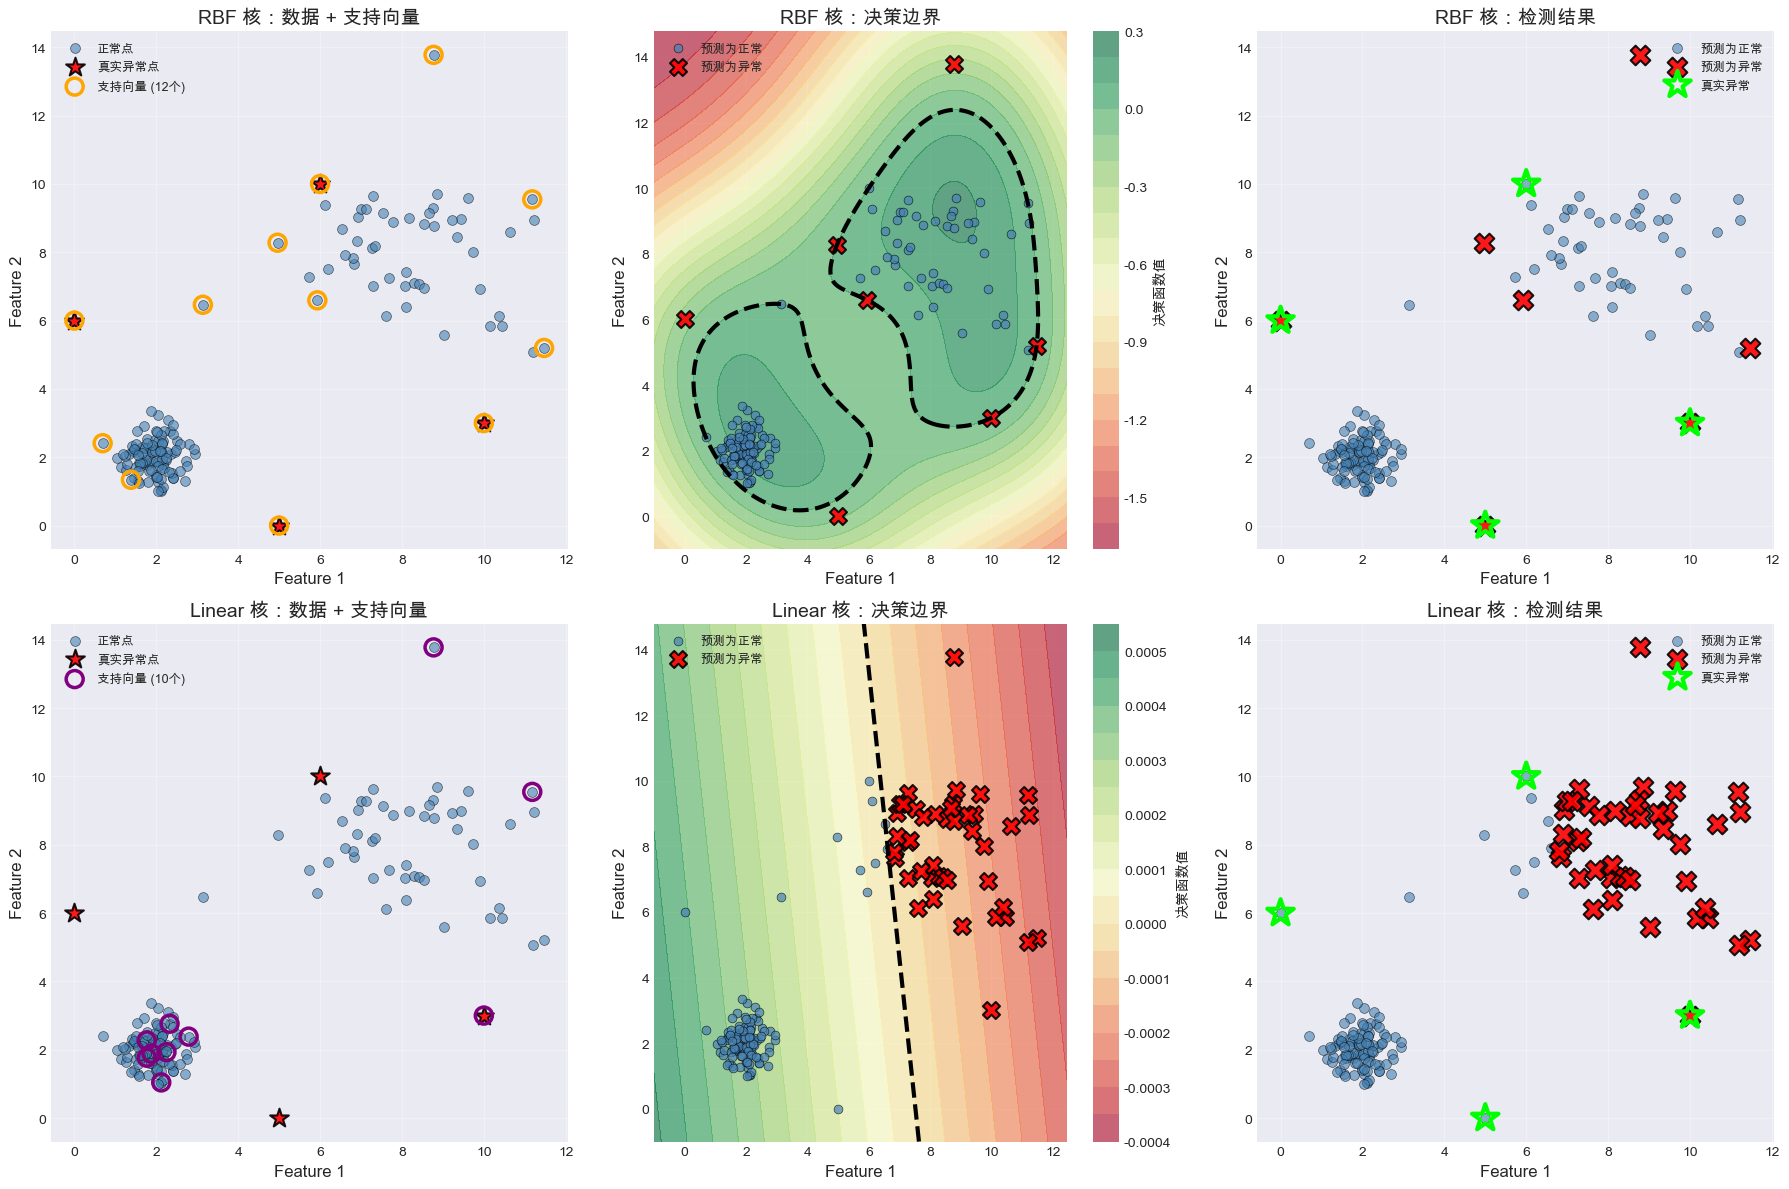


💡 观察：
  - RBF 核能捕捉非线性边界，适应数据分布
  - Linear 核生成线性边界，更简单但可能不够精确
  - 支持向量定义了决策边界的位置
  - 橙色圈=支持向量，黑色虚线=决策边界（f(x)=0）


In [16]:
# ============================================================================
# 可视化 One-Class SVM 结果：决策边界和支持向量
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ----------------------------------------------------------------------
# 第一行：RBF 核
# ----------------------------------------------------------------------

# 子图1：原始数据 + 支持向量（RBF）
ax1 = axes[0, 0]
# 绘制正常点
ax1.scatter(X_lof[y_true==0, 0], X_lof[y_true==0, 1],
           c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
           label='正常点')
# 绘制真实异常点
ax1.scatter(X_lof[y_true==1, 0], X_lof[y_true==1, 1],
           c='red', s=200, alpha=0.9, marker='*', edgecolors='black', linewidth=1.5,
           label='真实异常点')
# 标注支持向量
support_vectors = X_lof[ocsvm_rbf.support_]
ax1.scatter(support_vectors[:, 0], support_vectors[:, 1],
           s=150, facecolors='none', edgecolors='orange', linewidths=2.5,
           label=f'支持向量 ({len(ocsvm_rbf.support_)}个)')
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.set_title('RBF 核：数据 + 支持向量', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 子图2：决策边界热图（RBF）
ax2 = axes[0, 1]
# 创建网格
x_min, x_max = X_lof[:, 0].min() - 1, X_lof[:, 0].max() + 1
y_min, y_max = X_lof[:, 1].min() - 1, X_lof[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
# 预测网格点
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_scaled = scaler.transform(grid_points)
Z_rbf = ocsvm_rbf.decision_function(grid_points_scaled)
Z_rbf = Z_rbf.reshape(xx.shape)
# 绘制等高线（决策边界）
contour = ax2.contourf(xx, yy, Z_rbf, levels=20, cmap='RdYlGn', alpha=0.6)
ax2.contour(xx, yy, Z_rbf, levels=[0], linewidths=3, colors='black', linestyles='--')
# 绘制数据点
ax2.scatter(X_lof[predictions_ocsvm_rbf_binary==0, 0], X_lof[predictions_ocsvm_rbf_binary==0, 1],
           c='steelblue', s=40, alpha=0.7, edgecolors='black', linewidth=0.5,
           label='预测为正常')
ax2.scatter(X_lof[predictions_ocsvm_rbf_binary==1, 0], X_lof[predictions_ocsvm_rbf_binary==1, 1],
           c='red', s=150, alpha=0.9, marker='X', edgecolors='black', linewidth=1.5,
           label='预测为异常')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_title('RBF 核：决策边界', fontsize=14, fontweight='bold')
plt.colorbar(contour, ax=ax2, label='决策函数值')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 子图3：检测结果（RBF）
ax3 = axes[0, 2]
ax3.scatter(X_lof[predictions_ocsvm_rbf_binary==0, 0], X_lof[predictions_ocsvm_rbf_binary==0, 1],
           c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
           label='预测为正常')
ax3.scatter(X_lof[predictions_ocsvm_rbf_binary==1, 0], X_lof[predictions_ocsvm_rbf_binary==1, 1],
           c='red', s=200, alpha=0.9, marker='X', edgecolors='black', linewidth=1.5,
           label='预测为异常')
# 标注真实异常点的位置
for idx in np.where(y_true == 1)[0]:
    ax3.scatter(X_lof[idx, 0], X_lof[idx, 1],
               marker='*', s=400, facecolors='none', edgecolors='lime',
               linewidth=3, label='真实异常' if idx == np.where(y_true==1)[0][0] else '')
ax3.set_xlabel('Feature 1', fontsize=12)
ax3.set_ylabel('Feature 2', fontsize=12)
ax3.set_title('RBF 核：检测结果', fontsize=14, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# ----------------------------------------------------------------------
# 第二行：Linear 核
# ----------------------------------------------------------------------

# 子图4：原始数据 + 支持向量（Linear）
ax4 = axes[1, 0]
ax4.scatter(X_lof[y_true==0, 0], X_lof[y_true==0, 1],
           c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
           label='正常点')
ax4.scatter(X_lof[y_true==1, 0], X_lof[y_true==1, 1],
           c='red', s=200, alpha=0.9, marker='*', edgecolors='black', linewidth=1.5,
           label='真实异常点')
support_vectors_linear = X_lof[ocsvm_linear.support_]
ax4.scatter(support_vectors_linear[:, 0], support_vectors_linear[:, 1],
           s=150, facecolors='none', edgecolors='purple', linewidths=2.5,
           label=f'支持向量 ({len(ocsvm_linear.support_)}个)')
ax4.set_xlabel('Feature 1', fontsize=12)
ax4.set_ylabel('Feature 2', fontsize=12)
ax4.set_title('Linear 核：数据 + 支持向量', fontsize=14, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# 子图5：决策边界热图（Linear）
ax5 = axes[1, 1]
Z_linear = ocsvm_linear.decision_function(grid_points_scaled)
Z_linear = Z_linear.reshape(xx.shape)
contour2 = ax5.contourf(xx, yy, Z_linear, levels=20, cmap='RdYlGn', alpha=0.6)
ax5.contour(xx, yy, Z_linear, levels=[0], linewidths=3, colors='black', linestyles='--')
ax5.scatter(X_lof[predictions_ocsvm_linear_binary==0, 0], X_lof[predictions_ocsvm_linear_binary==0, 1],
           c='steelblue', s=40, alpha=0.7, edgecolors='black', linewidth=0.5,
           label='预测为正常')
ax5.scatter(X_lof[predictions_ocsvm_linear_binary==1, 0], X_lof[predictions_ocsvm_linear_binary==1, 1],
           c='red', s=150, alpha=0.9, marker='X', edgecolors='black', linewidth=1.5,
           label='预测为异常')
ax5.set_xlabel('Feature 1', fontsize=12)
ax5.set_ylabel('Feature 2', fontsize=12)
ax5.set_title('Linear 核：决策边界', fontsize=14, fontweight='bold')
plt.colorbar(contour2, ax=ax5, label='决策函数值')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 子图6：检测结果（Linear）
ax6 = axes[1, 2]
ax6.scatter(X_lof[predictions_ocsvm_linear_binary==0, 0], X_lof[predictions_ocsvm_linear_binary==0, 1],
           c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
           label='预测为正常')
ax6.scatter(X_lof[predictions_ocsvm_linear_binary==1, 0], X_lof[predictions_ocsvm_linear_binary==1, 1],
           c='red', s=200, alpha=0.9, marker='X', edgecolors='black', linewidth=1.5,
           label='预测为异常')
for idx in np.where(y_true == 1)[0]:
    ax6.scatter(X_lof[idx, 0], X_lof[idx, 1],
               marker='*', s=400, facecolors='none', edgecolors='lime',
               linewidth=3, label='真实异常' if idx == np.where(y_true==1)[0][0] else '')
ax6.set_xlabel('Feature 1', fontsize=12)
ax6.set_ylabel('Feature 2', fontsize=12)
ax6.set_title('Linear 核：检测结果', fontsize=14, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 观察：")
print("  - RBF 核能捕捉非线性边界，适应数据分布")
print("  - Linear 核生成线性边界，更简单但可能不够精确")
print("  - 支持向量定义了决策边界的位置")
print("  - 橙色圈=支持向量，黑色虚线=决策边界（f(x)=0）")



In [ ]:
# ============================================================================
# 性能评估：One-Class SVM
# ============================================================================

print("="*60)
print("One-Class SVM 性能评估")
print("="*60)

# RBF 核
print("\n【RBF 核】")
print("\n混淆矩阵:")
cm_rbf = confusion_matrix(y_true, predictions_ocsvm_rbf_binary)
print(cm_rbf)
print(f"\n  TN (正常预测为正常): {cm_rbf[0, 0]}")
print(f"  FP (正常预测为异常): {cm_rbf[0, 1]}")
print(f"  FN (异常预测为正常): {cm_rbf[1, 0]}")
print(f"  TP (异常预测为异常): {cm_rbf[1, 1]}")

print("\n分类报告:")
print(classification_report(y_true, predictions_ocsvm_rbf_binary, target_names=['正常', '异常']))

# Linear 核
print("\n" + "="*60)
print("【Linear 核】")
print("\n混淆矩阵:")
cm_linear = confusion_matrix(y_true, predictions_ocsvm_linear_binary)
print(cm_linear)
print(f"\n  TN (正常预测为正常): {cm_linear[0, 0]}")
print(f"  FP (正常预测为异常): {cm_linear[0, 1]}")
print(f"  FN (异常预测为正常): {cm_linear[1, 0]}")
print(f"  TP (异常预测为异常): {cm_linear[1, 1]}")

print("\n分类报告:")
print(classification_report(y_true, predictions_ocsvm_linear_binary, target_names=['正常', '异常']))

print("\n" + "="*60)
print("💡 One-Class SVM 的特点：")
print("  - 只需要正常样本训练，适合异常样本极少的场景")
print("  - RBF 核能捕捉复杂的非线性边界")
print("  - nu 参数控制异常比例上界")
print("  - 支持向量定义决策边界")
print("  - 需要数据标准化，对参数敏感")



In [ ]:
# ============================================================================
# 参数调优：nu 和 gamma 的影响
# ============================================================================

print("="*60)
print("参数调优演示")
print("="*60 + "\n")

# 测试不同的 nu 值
nu_values = [0.01, 0.05, 0.1, 0.2, 0.5]
gamma_values = ['auto', 0.01, 0.1, 1.0]

print("【nu 参数的影响】（固定 gamma='scale'）\n")
fig, axes = plt.subplots(1, len(nu_values), figsize=(20, 4))

for idx, nu in enumerate(nu_values):
    # 训练模型
    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu, )
    preds = model.fit_predict(X_lof_scaled)
    n_anomalies = np.sum(preds == -1)
    n_support = len(model.support_)
    
    # 可视化
    ax = axes[idx]
    Z = model.decision_function(grid_points_scaled).reshape(xx.shape)
    ax.contourf(xx, yy, Z, levels=20, cmap='RdYlGn', alpha=0.5)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    ax.scatter(X_lof[preds==1, 0], X_lof[preds==1, 1],
              c='steelblue', s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.scatter(X_lof[preds==-1, 0], X_lof[preds==-1, 1],
              c='red', s=80, alpha=0.9, marker='X', edgecolors='black', linewidth=1)
    ax.set_title(f'nu={nu}\n异常:{n_anomalies}, SV:{n_support}', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Feature 1', fontsize=10)
    ax.set_ylabel('Feature 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    print(f"nu={nu:4.2f}: 异常点={n_anomalies:3d} ({n_anomalies/len(X_lof)*100:5.1f}%), " + 
          f"支持向量={n_support:3d} ({n_support/len(X_lof)*100:5.1f}%)")

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("【gamma 参数的影响】（固定 nu=0.05）\n")
fig, axes = plt.subplots(1, len(gamma_values), figsize=(20, 4))

for idx, gamma in enumerate(gamma_values):
    # 训练模型
    model = OneClassSVM(kernel='rbf', gamma=gamma, nu=0.05, )
    preds = model.fit_predict(X_lof_scaled)
    n_anomalies = np.sum(preds == -1)
    
    # 可视化
    ax = axes[idx]
    Z = model.decision_function(grid_points_scaled).reshape(xx.shape)
    ax.contourf(xx, yy, Z, levels=20, cmap='RdYlGn', alpha=0.5)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    ax.scatter(X_lof[preds==1, 0], X_lof[preds==1, 1],
              c='steelblue', s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.scatter(X_lof[preds==-1, 0], X_lof[preds==-1, 1],
              c='red', s=80, alpha=0.9, marker='X', edgecolors='black', linewidth=1)
    ax.set_title(f'gamma={gamma}\n异常:{n_anomalies}', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Feature 1', fontsize=10)
    ax.set_ylabel('Feature 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    print(f"gamma={str(gamma):6s}: 异常点={n_anomalies:3d} ({n_anomalies/len(X_lof)*100:5.1f}%)")

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("💡 参数调优建议：")
print("  【nu 参数】")
print("    - nu 越小 → 边界越紧 → 检测出的异常越少")
print("    - nu 越大 → 边界越松 → 检测出的异常越多")
print("    - 建议：根据预期异常比例设置（通常 0.01-0.1）")
print("\n  【gamma 参数（RBF 核）】")
print("    - gamma 越小 → 边界越平滑 → 更全局")
print("    - gamma 越大 → 边界越复杂 → 更局部，易过拟合")
print("    - 建议：先用 'scale' 或 'auto'，再微调")



## 7. 算法对比与选择

### 7.1 四种算法全面对比

| 特性 | 3-Sigma | LOF | Isolation Forest | One-Class SVM |
|------|---------|-----|------------------|---------------|
| **类型** | 统计方法 | 基于密度 | 基于树 | 基于边界 |
| **核心思想** | 标准差阈值 | 局部密度对比 | 路径长度 | 学习正常数据边界 |
| **适用数据** | 一维/低维 | 低维（≤10） | 高维OK | 低维/中维 |
| **时间复杂度** | O(n) | O(n²) | O(t·ψ·log ψ) | O(n²~n³) |
| **空间复杂度** | O(1) | O(n²) | O(t·ψ) | O(n) |
| **可扩展性** | ⭐⭐⭐ | ⭐ | ⭐⭐⭐ | ⭐⭐ |
| **参数数量** | 1 (阈值) | 1 (k) | 2-3 | 2-3 |
| **处理多簇** | ❌ | ✅ | ✅ | ✅ |
| **局部异常** | ❌ | ✅ | ✅ | ✅ |
| **训练速度** | 极快 | 慢 | 快 | 中等 |
| **预测速度** | 极快 | 快 | 快 | 快 |
| **内存占用** | 极小 | 大 | 中 | 中 |
| **可解释性** | ⭐⭐⭐ | ⭐⭐ | ⭐⭐ | ⭐⭐ |
| **是否需要标准化** | ✅ | ✅ | ❌ | ✅ |

---

### 7.2 算法选择指南

#### 📊 场景1：简单一维数据

**推荐**：3-Sigma

**原因**：
- 数据服从正态分布
- 只需检测全局异常
- 需要快速结果

**示例**：传感器单一指标异常检测

---

#### 📊 场景2：多密度簇数据

**推荐**：LOF

**原因**：
- 数据有多个密度不同的簇
- 需要检测局部异常
- 数据量不大（<10,000）

**示例**：不同收入群体的消费异常检测

---

#### 📊 场景3：大规模高维数据

**推荐**：Isolation Forest

**原因**：
- 数据量大（>10,000）
- 特征维度高（>10）
- 需要快速训练和预测

**示例**：
- 网络流量异常检测（百万级记录）
- 日志异常检测（高维特征）

---

#### 📊 场景4：实时异常检测

**推荐**：3-Sigma 或 Isolation Forest

**原因**：
- 需要低延迟
- LOF 的 O(n²) 复杂度太高

---

#### 📊 场景5：需要可解释性

**推荐**：3-Sigma

**原因**：
- 业务人员容易理解「超过3个标准差」
- LOF 和 Isolation Forest 较难解释

**示例**：金融合规审计

---

### 7.3 参数调优建议

#### 3-Sigma
- **threshold**：通常设置为 2.5 ~ 3.5
  - 2.5：更敏感，检测更多异常
  - 3.5：更保守，只检测极端异常

#### LOF
- **n_neighbors** (k)：
  - 小数据集（<1000）：k = 10-20
  - 大数据集：k = 20-50
  - 建议：先用 20 尝试

#### Isolation Forest
- **n_estimators**（树的数量）：
  - 默认：100
  - 更多树 → 更稳定，但更慢
  - 建议：100-200

- **contamination**（预期异常比例）：
  - 如果知道异常比例，设置为该值
  - 如果不知道，设置为 0.05-0.1
  - 影响阈值

- **max_samples**（子采样大小）：
  - 默认：'auto'（min(256, n_samples)）
  - 较小值 → 更快，但可能不稳定
  - 建议：保持默认

---


## 8. 小结与最佳实践
### 8.1 核心要点回顾
#### 🎯 异常检测的本质
- **目标**：发现数据中「与众不同」的观测值
- **类型**：点异常、上下文异常、集体异常
- **应用**：欺诈检测、故障预测、入侵检测等

#### 🎯 四种核心算法
**1. 3-Sigma（统计方法）**
- ✅ **公式**：$z = \frac{x - \mu}{\sigma}$，$|z| > 3$ 为异常
- ✅ **优势**：简单快速，易于理解
- ❌ **局限**：只适合正态分布，无法处理多簇
- 💡 **适用**：一维数据，快速筛查

**2. LOF（局部异常因子）**
- ✅ **公式**：$\text{LOF}_k(A) = \frac{\text{邻居的平均密度}}{\text{自己的密度}}$
- ✅ **优势**：能处理多密度簇，检测局部异常
- ❌ **局限**：O(n²) 复杂度，不适合大数据
- 💡 **适用**：多簇数据，局部异常检测

**3. Isolation Forest（孤立森林）**
- ✅ **公式**：$s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$
- ✅ **优势**：速度快，适合高维和大数据
- ❌ **局限**：可解释性较差
- 💡 **适用**：大规模、高维数据

---

**4. One-Class SVM（一类支持向量机）**- ✅ **公式**：$f(\mathbf{x}) = \text{sign}(\sum \alpha_i K(\mathbf{x}_i, \mathbf{x}) - \rho)$- ✅ **优势**：学习正常数据边界，只需正常样本- ❌ **局限**：训练较慢，对参数敏感- 💡 **适用**：只有正常样本，需要明确边界### 8.2 最佳实践指南
#### 📋 数据预处理

1. **标准化**（对 3-Sigma 和 LOF）
   ```python
   from sklearn.preprocessing import StandardScaler
   scaler = StandardScaler()
   X_scaled = scaler.fit_transform(X)
   ```

2. **处理缺失值**
   - 删除或填充（使用均值/中位数）
   - 缺失值本身可能是异常的信号

3. **特征选择**
   - 移除无关特征
   - 保留对异常检测有意义的特征

#### 📋 模型选择流程

```
开始
 ↓
数据量大吗？（>10,000）
 ├─ 是 → 使用 Isolation Forest
 ├─ 否 → 数据有多个密度不同的簇吗？
         ├─ 是 → 使用 LOF
         └─ 否 → 数据是一维且服从正态分布吗？
                 ├─ 是 → 使用 3-Sigma
                 └─ 否 → 使用 Isolation Forest
```

#### 📋 参数调优

1. **交叉验证**
   - 如果有少量标注异常，使用它们调优参数
   - 否则，使用领域知识设置

2. **阈值选择**
   - 业务优先级：
     - 高召回率（不漏检）→ 较低阈值
     - 高精确率（不误报）→ 较高阈值
   
3. **集成方法**
   - 多种算法投票
   - 取交集或并集

#### 📋 评估策略

**有标签时**：
```python
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
```

**无标签时**：
- 人工抽样检查
- 领域专家验证
- 监控下游业务指标

#### 📋 常见陷阱

1. **❌ 陷阱1**：在不平衡数据上使用准确率
   - ✅ **正确**：使用 Precision、Recall、F1

2. **❌ 陷阱2**：忘记标准化
   - ✅ **正确**：3-Sigma 和 LOF 必须标准化

3. **❌ 陷阱3**：过度依赖单一算法
   - ✅ **正确**：尝试多种算法，选择最佳

4. **❌ 陷阱4**：忽略业务背景
   - ✅ **正确**：结合领域知识解释异常

---

### 8.3 进阶主题（扩展学习）
本 Notebook 未涵盖，但值得进一步学习：

1. **One-Class SVM**
   - 学习正常数据的边界
   - 适合只有正常样本的情况

2. **Autoencoder（自编码器）**
   - 深度学习方法
   - 适合图像、文本等复杂数据

3. **时间序列异常检测**
   - ARIMA 残差检测
   - LSTM Autoencoder
   - Prophet

4. **集成异常检测**
   - Feature Bagging
   - LODA (Lightweight On-line Detector of Anomalies)

---

### 8.4 检查清单
完成本 Notebook 后，你应该能够：

- [ ] ✅ 理解异常检测的定义和应用场景
- [ ] ✅ 解释 3-Sigma 规则的原理和公式
- [ ] ✅ 理解 LOF 的五个步骤及其公式
- [ ] ✅ 理解 Isolation Forest 的核心思想（路径长度）
- [ ] ✅ 理解 One-Class SVM 的原理（决策边界）- [ ] ✅ 根据数据特点选择合适的算法
- [ ] ✅ 实现并应用四种异常检测算法- [ ] ✅ 评估异常检测结果的质量
- [ ] ✅ 避免常见的异常检测陷阱

---

### 8.5 推荐资源
**论文**：
1. Breunig et al. (2000) - *LOF: Identifying Density-Based Local Outliers*
2. Liu et al. (2008) - *Isolation Forest*

**书籍**：
3. *Outlier Analysis* - Charu C. Aggarwal

**库**：
4. `sklearn.ensemble.IsolationForest`
5. `sklearn.neighbors.LocalOutlierFactor`
6. `PyOD` - Python Outlier Detection library

---

### 🎉 恭喜！

你已经掌握了异常检测的核心算法和实践技巧！

**下一步**：
- 在真实数据集上练习
- 尝试 Kaggle 异常检测竞赛
- 探索深度学习异常检测方法

**记住**：
> 「异常检测是一门艺术，而非科学。」
> 
> 没有完美的算法，只有最适合你数据和业务的算法。

---

**💪 继续学习，保持好奇心！**